# Константы

In [11]:
# Константы
AU = 149597870.7  # км
R_sun = 700000  # км
MU_sun = 132712440019.  # км ^ 3 / с ^2

# Единицы измерения
DU = AU  # Задано в км
TU = 60 * 60 * 24.  # Задано в секундах; сейчас это 1 день
VU = DU / TU
CU = DU / (TU ** 2)  # км / с ^ 2

# Константы
MU_in_units = MU_sun * (TU ** 2 / DU ** 3)  # DU^3/TU^2
AU_in_units = AU / DU
R_sun_in_units = R_sun / DU

c_light = 299_792_458  # m/s
E_Earth = 1372.  # Wt/m^2 = kg / s^3
P_Earth = E_Earth / c_light  # kg / (m * s^2)

# solar pressure at one astronomical unit (AU)
P_au = P_Earth * TU ** 2 / (DU * 1e3)  # N_in_units / m^2 = (kg * DU / TU^2) / m^2

# Начальные параметры

In [1]:
# Начальные параметры 
import numpy as np

#a_c = 0.25  / (CU * 1e6) # мм / с^2 -> DU/TU^2
  # Характеристическое ускорение
# коэффициент отражения
r = 0.91

# non-Lambertian coefficients
B_f = 0.79  # front
B_b = 0.67  # back
e_f = 0.025  # излучение от передней поверхности
e_b = 0.27
s = 1

# m_del_A = P_au * ((1 + r * s) + B_f * (1 - s) * r + (1 - r) *
#                       ((e_f * B_f - e_b * B_b) / (e_f + e_b))) /  a_c_values # кг / м^2

# A_del_m = 1 / m_del_A


# GravityForce

In [2]:
# Gravity force
import numpy as np
def gravity_acceleration(r: np.array) -> np.array:
    # r должно быть в DU
    global MU_in_units
    r_magnitude = np.linalg.norm(r)
    return - MU_in_units * r / (r_magnitude ** 3)


# Вычисление угла управления 

In [3]:
# Вычисление угла управления 
def angles_for_max_projection(p: np.ndarray) -> tuple[float, float]:
    """
    Вычисляет оптимальные углы альфа и дельта паруса для максимизации проекции силы тяги
    на произвольное направление, заданное вектором p.
    
    :param p: Направляющий вектор в ОСК
    :return: Оптимальные углы в радианах
    """
    if p.shape != (3,):
        raise ValueError("Вектор p должен быть размерности (3,)")

    # Нормализуем вектор p
    p = p / np.linalg.norm(p)

    # Проверяем диапазон для arccos
    cos_alpha =  p[0]
    cos_alpha = np.clip(cos_alpha, -1.0, 1.0)
    
    p_alpha = p - np.array([cos_alpha, 0, 0])
    cos_delta = p_alpha @ np.array([0, 1, 0])
    sin_delta = p_alpha @ np.array([0, 0, 1])
    
    delta = np.atan2(sin_delta, cos_delta)
    # print("Alpha:", np.arccos(cos_alpha) * 180 / np.pi)
    # print("Delta:", delta * 180 / np.pi)
    # Оптимальные углы для нормали
    cos_psi = cos_alpha # TO DO: remove psi; rename angle so as to distinguish angles corresponding do different vectors
    sqrt_cos_psi = cos_psi * np.sqrt(8 + cos_psi ** 2)

    cos2_a = (8 / 3) * (3 + sqrt_cos_psi) / (12 + cos_psi ** 2 + sqrt_cos_psi)
    cos2_a = np.clip(cos2_a, 0.0, 1.0)  # cos²(a) должен быть в [0,1]

    cos_a = np.sqrt(cos2_a)
    alpha_opt = np.arccos(cos_a)
    delta_opt = delta  # Оптимально совпадает с направлением

    return alpha_opt, delta_opt

# SolarForce

In [4]:
# Solar force 
import math

def solar_force(r_i: np.array, v_i: np.array, A_del_m_: float) -> np.array:

    """
    Вычисляет силу давления солнечного света на солнечный парус.

    Параметры:
        r_i (np.array): радиус-вектор спутника в ИСК (м).
        v_i (np.array): вектор скорости спутника в ИСК (м/с).
        psi (float): угол между скоростью и радиусом-вектором (рад).
        delta (float): дополнительный угол управления (рад).

    Возвращает:
        np.array: сила давления солнечного света в ИСК (Н/кг).
    """

    # Вектор углового момента и его модуль
    c_i = np.cross(r_i, v_i)
    c_i_norm = np.linalg.norm(c_i)

    # Нормализация радиус-вектора
    r_norm = np.linalg.norm(r_i)
    e1 = r_i / r_norm
    e3 = c_i / c_i_norm
    e2 = np.cross(e3, e1)

    # Матрица перехода из ОСК в ИСК
    transformation_matrix = np.array([e1, e2, e3]).T

    # Скорость в ОСК
    v_orbital = transformation_matrix.T @ v_i

    # Углы управления α, delta
    alpha, delta = angles_for_max_projection(-v_orbital)

    # Нормаль к поверхности паруса в орбитальной СК
    sail_normal = np.array([
        np.cos(alpha),
        np.cos(delta) * np.sin(alpha),
        np.sin(delta) * np.sin(alpha)
    ]) 
   
    sail_normal_e = sail_normal / np.linalg.norm(sail_normal)
    # Направление солнечного света в орбитальной СК
    solar_direction = np.array([1, 0, 0])
    cos_a = np.dot(sail_normal_e, solar_direction)
    sin_a = np.sqrt(1 - cos_a ** 2)

    # Давление солнечного света
    pressure = P_au * (AU_in_units / r_norm) ** 2

    # Компоненты силы давления
    f_n = pressure * (
        (1 + r * s) * cos_a ** 2 +
        B_f * (1 - s) * r * cos_a +
        (1 - r) * ((e_f * B_f - e_b * B_b) / (e_f + e_b)) * cos_a
    )
    f_t = pressure * (1 - r * s) * cos_a * sin_a

    # Сила в орбитальной СК
    force_orbital = f_n * sail_normal + f_t * np.array([0, 1, 0])

    # Сила в инерциальной СК
    force_inertial = np.dot(transformation_matrix, force_orbital)

    return force_inertial * A_del_m_


# Derivatives

In [5]:
# Derivatives 
import numpy as np
def derivatives(t, y):
    r_i = y[:3]  # Позиция
    v_i = y[3:6]  # Скорость

    a_del_m_i = y[6]
    # Ускорение
    a_grav = gravity_acceleration(r_i)
    a_solar = solar_force(r_i, v_i, a_del_m_i)
    a = a_grav + a_solar
    da_del_m_dt = 0

    return np.hstack((v_i, a, da_del_m_dt))


In [6]:
# Энергия 
def hyperbolic_orbit_energy(x: float, y: float, z: float, vx: float, vy: float, vz: float) -> np.ndarray:
    """
    Вычисляет удельную энергию спутника на гиперболической орбите.
    
    :param solution: Массив решения с координатами и скоростями спутника
    :param mu: Гравитационный параметр центрального тела
    :return: Массив удельных энергий во времени
    """
    
    r = np.sqrt(x**2 + y**2 + z**2)
    v2 = vx**2 + vy**2 + vz**2
    energy = 0.5 * v2 - MU_in_units / r
    
    return energy

# Events (точки останова)

In [7]:
# Точки останова
import numpy as np
# Событие: Перицентр
def detect_pericenter(t, y):
    r_i = y[:3]  # Позиция
    v_i = y[3:6]  # Скорость
    vr = np.dot(r_i, v_i) / np.linalg.norm(r_i)  # Радиальная скорость
    return vr  # Условие: радиальная скорость равна нулю


# Настройки для перицентра
detect_pericenter.terminal = False  # Не останавливаем на перицентре
detect_pericenter.direction = 1  # Интересует момент, когда vr меняется с - на +


# Функция события: детектирование апоцентра
def detect_apocenter(t, y):
    r_i = y[:3]  # Позиция
    v_i = y[3:6]  # Скорость

    vr = np.dot(r_i, v_i) / np.linalg.norm(r_i)  # Радиальная скорость
    return vr  # Условие: радиальная скорость равна нулю

# Настройки события
detect_apocenter.terminal = True  # Прекратить интеграцию при апоцентре
detect_apocenter.direction = -1  # Интересует только момент, когда vr меняется с + на -

def detect_h_minus(t, y):
    r_i = y[:3]  # Позиция
    v_i = y[3:6]  # Скорость
    h = hyperbolic_orbit_energy(r_i[0], r_i[1], r_i[2], v_i[0], v_i[1], v_i[2])
    return h
# Настройки события
detect_h_minus.terminal = True  # Остановить интегрирование, когда h = 0
detect_h_minus.direction = 1   # Определять только переход h с - на +


# Функции конвертации

In [8]:
# Функция конвертации 
def orbital_elements_to_state(a, e, i, Omega, omega, nu, mu):
    # a - большая полуось (м)
    # e - эксцентриситет
    # i - наклонение (рад)
    # Omega - долгота восходящего узла (рад)
    # omega - аргумент перицентра (рад)
    # nu - истинная аномалия (рад)
    # mu - гравитационный параметр (м^3/с^2)

    # 1. Вычисление радиус-вектора r

    p = a * (1 - e * e)
    distance = p / (1 + e * np.cos(nu))

    # 2. Вектор в орбитальной системе координат
    r_orbital = np.array([1, 0, 0]) * distance

    # 3. Вектор скорости в орбитальной системе координат

    velocity = np.array([np.sqrt(MU_in_units / p) * e * np.sin(nu),
                         np.sqrt(MU_in_units / p) * (1 + e * np.cos(nu)),
                         0])

    # 4. Преобразование вектора в инерциальную систему координат
    R3_W = np.array([[np.cos(Omega), np.sin(Omega), 0],
                     [-np.sin(Omega), np.cos(Omega), 0],
                     [0, 0, 1]])
    R1_i = np.array([[1, 0, 0], [0, np.cos(i), np.sin(i)], [0, np.sin(i), np.cos(i)]])

    u = omega + nu
    R3_w = np.array([[np.cos(u), np.sin(u), 0],
                     [-np.sin(u), np.cos(u), 0],
                     [0, 0, 1]])
    R = R3_W @ R1_i @ R3_w

    # 5. Преобразование радиус-вектора и вектора скорости
    r_inertial = R.T @ r_orbital
    v_inertial = R.T @ velocity

    return r_inertial, v_inertial


# Интегрирование для разных скоростей V

In [9]:
# # Основная функция интегрирования 

# import numpy as np
# from scipy.integrate import solve_ivp
# import matplotlib.pyplot as plt


# # Массив различных значений v_inf
# v_inf_values =  [40]  # Примерные значения для v_inf, км/с


# # Подготовка пустых массивов для сохранения данных по графикам
# a_arr_all = []
# omega_arr_all = []
# e_arr_all = []
# nu_arr_all = []
# times_all = []
# trajectory_all = []
# energy_all = []
# times_all = []
# r0_norm = 10 * AU_in_units
# r_p = 0.05 * AU_in_units

# # Функция для интегрирования для разных v_inf
# def integrate_for_v_inf(v_inf):
#     global r0_norm, r_p
#     # Пересчитываем начальные условия на основе v_inf
#     a = -MU_in_units / (v_inf ** 2)
#     e = 1 - r_p / a
#     omega = 180 / 180 * np.pi
#     Omega = 0
#     i = 0
#     # Истинная аномалия
#     cos_nu = (a * (1 - e**2) - r0_norm) / (r0_norm * e)
#     if abs(cos_nu) > 1:  # Проверка на допустимость
#         raise ValueError("cos_nu выходит за пределы [-1, 1]! Проверьте входные параметры.")

#     nu = - np.arccos(cos_nu)  # Истинная аномалия, движение к Солнцу

#     # Преобразуем орбитальные элементы в начальные условия
#     r0_initial, v0_initial = orbital_elements_to_state(a, e, i, Omega, omega, nu, MU_in_units)

#     # Объединение начальных условий в один массив
#     initial_conditions = np.hstack((r0_initial, v0_initial))

#     # Время интегрирования
#     t_span = (0, 365 * 24 * 60 * 60 * 1.5/ TU)  # Сколько-то лет в секундах
#     t_eval = np.linspace(t_span[0], t_span[1], num=10_000)  # Временные точки для оценки

#     # Решение системы дифференциальных уравнений
#     solution = solve_ivp(
#         derivatives,
#         t_span,
#         initial_conditions,
#         method='RK45',
#         t_eval=t_eval,
#         rtol=1e-12,
#         atol=1e-12,
#         events=[detect_pericenter, detect_apocenter]  # Указываем оба события
#     )

#     # Извлечение координат
#     x = solution.y[0]
#     y = solution.y[1]
#     z = solution.y[2]
#     vx = solution.y[3]
#     vy = solution.y[4]
#     vz = solution.y[5]
#     times = solution.t  # Времена
#     times_all.append(times)
#     energy = hyperbolic_orbit_energy(x, y, z, vx, vy, vz)
#     energy_all.append(energy)
#     trajectory = solution.y.T
#     trajectory_all.append(trajectory)


# # Интегрируем для всех значений v_inf
# for v_inf in v_inf_values:
#     integrate_for_v_inf(v_inf / VU)
# trajectory_all = np.array(trajectory_all)


In [10]:
# Функция перебора параметров 
import h5py
from scipy.integrate import solve_ivp
r_p_values = np.arange(10, 45,  5) * R_sun_in_units  # Перицентр 
v_inf_values = np.arange(10, 125, 5) / VU # Начальная скорость (10–120 км/с)
a_c_values_ = np.arange(0.25, 3.25, 0.20) / (CU * 1e6)
a_c_one = np.array([0.1, 0.2]) / (CU * 1e6)
a_c_values = np.hstack((a_c_one, a_c_values_))
# r_p_values = np.array([10, 20, 30]) * R_sun_in_units  # Перицентр 
# v_inf_values = np.array([60, 70, 80]) / VU # Начальная скорость (10–120 км/с)
# a_c_values = np.array([2, 3, 3.5]) / (CU * 1e6)

r0_norm = 10 * AU_in_units
# Файл для сохранения данных
output_filename = "trajectories.h5"

# Открываем файл HDF5 для записи
with h5py.File(output_filename, 'w') as f:
    # Создаем группы для хранения параметров и траекторий
    group_params = f.create_group('parameters')
    group_trajectories = f.create_group('trajectories')
    
    # Сохраняем параметры в HDF5
    group_params.create_dataset('a_c_values', data=a_c_values)
    group_params.create_dataset('r_p_values', data=r_p_values)
    group_params.create_dataset('v_inf_values', data=v_inf_values)
    
    # Индекс для хранения данных по траекториям
    traj_index = 0
  
    # Цикл по параметрам
    for a_c in a_c_values:
        for r_p in r_p_values:
            skip_v_inf = False 
            for v_inf in v_inf_values:
                if skip_v_inf:
                    break  # Выходим из цикла по v_inf, если найдено E > 0

                try:

                    # Пересчет начальных условий
                    a = -MU_in_units / (v_inf ** 2)
                    e = 1 - r_p / a
                    omega = np.pi  # 180 градусов
                    Omega = 0
                    i = 0

                    # Истинная аномалия
                    cos_nu = (a * (1 - e ** 2) - r0_norm) / (r0_norm * e)
                    if abs(cos_nu) > 1:
                        continue  # Пропускаем некорректные значения

                    nu = -np.arccos(cos_nu)
                    r0_initial, v0_initial = orbital_elements_to_state(a, e, i, Omega, omega, nu, MU_in_units)

                    m_del_A = P_au * ((1 + r * s) + B_f * (1 - s) * r + (1 - r) *
                                    ((e_f * B_f - e_b * B_b) / (e_f + e_b))) / a_c

                    A_del_m = 1 / m_del_A
                    initial_conditions = np.hstack((r0_initial, v0_initial, A_del_m))

                    # Время интегрирования
                    t_span = (0, 365 * 24 * 60 * 60 * 6 / TU)
                    t_eval = np.linspace(t_span[0], t_span[1], num=10_000)

                    # Интегрирование
                    solution = solve_ivp(
                        derivatives,
                        t_span,
                        initial_conditions,
                        method='RK45',
                        t_eval=t_eval,
                        rtol=1e-8,
                        atol=1e-8,
                        events=[detect_pericenter, detect_apocenter]
                    )

                    r_end = np.array([solution.y[0, :], solution.y[1, :], solution.y[2, :]]) 
                    v_end = np.array([solution.y[3, :], solution.y[4, :], solution.y[5, :]]) 
                    v_last = np.linalg.norm(v_end[:, -1])   
                    r_last = np.linalg.norm(r_end[:, -1])
                     # Рассчитываем полную энергию орбиты
                    E = 0.5 * v_last**2 - MU_in_units / r_last
                    if E > 0:
                        print(f"Энергия стала положительной при v_inf={v_inf * VU}, r_p={r_p / R_sun_in_units}. Прекращаем перебор v_inf.")
                        skip_v_inf = True  # Дальше проверять не нужно
                        break

                    # Сохраняем траектории в HDF5
                    traj_group = group_trajectories.create_group(f'trajectory_{traj_index}')
                    traj_group.create_dataset('a_c', data=a_c)
                    traj_group.create_dataset('r_p', data=r_p)
                    traj_group.create_dataset('v_inf', data=v_inf)
                    traj_group.create_dataset('time', data=solution.t)
                    traj_group.create_dataset('x', data=solution.y[0, :])
                    traj_group.create_dataset('y', data=solution.y[1, :])
                    traj_group.create_dataset('z', data=solution.y[2, :])
                    traj_group.create_dataset('vx', data=solution.y[3, :])
                    traj_group.create_dataset('vy', data=solution.y[4, :])
                    traj_group.create_dataset('vz', data=solution.y[5, :])

                    traj_index += 1
                    print(f"Интегрирование завершено для a_c={a_c * CU * 1e6}, r_p={r_p / R_sun_in_units}, v_inf={v_inf * VU}")

                except Exception as e:
                    print(f"Ошибка при обработке a_c={a_c}, r_p={r_p}, v_inf={v_inf}: {e}")

NameError: name 'R_sun_in_units' is not defined

In [ ]:
#

In [ ]:
import h5py
import numpy as np

# Открываем файл HDF5 для чтения
output_filename = "trajectories.h5"
trajectory_all = []
energy_all = []
times_all = []
v_inf_max_all = []
r_min_all = []
a_c_all = []
prev_r_p = None
# Создаем словарь для хранения значений v_inf для каждой пары (r_p, a_c)
v_inf_dict = {}
r_p_dict = {}
with h5py.File(output_filename, 'r') as f:
    # Чтение параметров
    a_c_values = f['parameters/a_c_values'][:]
    r_p_values = f['parameters/r_p_values'][:]
    v_inf_values = f['parameters/v_inf_values'][:]
    # Чтение траекторий
    for traj_index in range(len(f['trajectories'])):
        traj_group = f[f'trajectories/trajectory_{traj_index}']
        
        # Извлекаем данные для каждой траектории
        a_c = traj_group['a_c'][()]
        r_p = traj_group['r_p'][()]
        v_inf = traj_group['v_inf'][()]
        # Преобразуем его в numpy массив
        # Берем последнее значение v_inf

        # Добавляем a_c в список
        a_c_all.append(a_c)
        # Если для данной пары (r_p, a_c) ещё нет в словаре, добавляем новый ключ
        if (r_p, a_c) not in v_inf_dict:
            v_inf_dict[(r_p, a_c)] = []

        # Добавляем значения v_inf для данной пары (r_p, a_c) в словарь
        v_inf_dict[(r_p, a_c)].append(v_inf)  # append добавляет одиночный элемент

        # Если для данного r_p еще нет в словаре, добавляем новый ключ
        if r_p not in r_p_dict:
            r_p_dict[r_p] = []

        # Добавляем пару (a_c, v_inf) в список для данного r_p
        r_p_dict[r_p].append((a_c, v_inf))  # добавляем пару (a_c, v_inf)

        # Рассчитываем минимальное расстояние r_min
        time = traj_group['time'][:]
        x = traj_group['x'][:]
        y = traj_group['y'][:]
        z = traj_group['z'][:]
        vx = traj_group['vx'][:]
        vy = traj_group['vy'][:]
        vz = traj_group['vz'][:]
        
        # Рассчитываем расстояние до Солнца в каждый момент времени
        r_apocenter = np.sqrt(x**2 + y**2 + z**2)
        r_min = np.min(r_apocenter)
        r_min_all.append(r_min)

        # Считаем энергию орбиты
        trajectory = np.column_stack((
            traj_group['x'][:], traj_group['y'][:], traj_group['z'][:],
            traj_group['vx'][:], traj_group['vy'][:], traj_group['vz'][:]
        ))
        energy = hyperbolic_orbit_energy(x, y, z, vx, vy, vz)
        energy_all.append(energy)
        trajectory_all.append(trajectory)
        times_all.append(time)
# Теперь r_p_dict содержит все пары (a_c, v_inf) для каждого r_p
# Для каждого r_p создадим список всех значений a_c и соответствующих максимальных значений v_inf
r_p_max_v_inf_dict = {}
#Печать всех ключей и значений из словаря r_p_dict
for r_p_val, a_c_v_inf_pairs in r_p_dict.items():
    print(f"r_p = {r_p_val / R_sun_in_units}:")
    for a_c, v_inf in a_c_v_inf_pairs:
        print(f"    a_c = {a_c * CU * 1e6}, v_inf = {v_inf * VU}")
# Проходим по всем ключам и значениям из r_p_dict
for r_p_val, a_c_v_inf_pairs in r_p_dict.items():
    # Для каждого r_p создаём список для хранения максимальных значений v_inf по каждому a_c
    max_v_inf_for_r_p = {}
    
    for a_c, v_inf in a_c_v_inf_pairs:
        # Если для данного a_c ещё нет записи, добавляем его в словарь
        if a_c not in max_v_inf_for_r_p:
            max_v_inf_for_r_p[a_c] = v_inf
        else:
            # Если a_c уже есть, то выбираем максимальное значение
            max_v_inf_for_r_p[a_c] = max(max_v_inf_for_r_p[a_c], v_inf)
    
    # Сохраняем результат для текущего r_p
    r_p_max_v_inf_dict[r_p_val] = max_v_inf_for_r_p

# Печать максимальных значений v_inf для каждого r_p и a_c
for r_p_val, a_c_max_v_inf_pairs in r_p_max_v_inf_dict.items():
    print(f"r_p = {r_p_val / R_sun_in_units}:")
    for a_c, max_v_inf in a_c_max_v_inf_pairs.items():
        print(f"    a_c = {a_c * CU * 1e6}, max(v_inf) = {max_v_inf * VU}")



r_p = 10.0:
    a_c = 0.1, v_inf = 10.0
    a_c = 0.1, v_inf = 15.0
    a_c = 0.1, v_inf = 20.0
    a_c = 0.1, v_inf = 25.0
    a_c = 0.1, v_inf = 30.0
    a_c = 0.2, v_inf = 10.0
    a_c = 0.2, v_inf = 15.0
    a_c = 0.2, v_inf = 20.0
    a_c = 0.2, v_inf = 25.0
    a_c = 0.2, v_inf = 30.0
    a_c = 0.2, v_inf = 35.0
    a_c = 0.2, v_inf = 40.0
    a_c = 0.2, v_inf = 45.0
    a_c = 0.25, v_inf = 10.0
    a_c = 0.25, v_inf = 15.0
    a_c = 0.25, v_inf = 20.0
    a_c = 0.25, v_inf = 25.0
    a_c = 0.25, v_inf = 30.0
    a_c = 0.25, v_inf = 35.0
    a_c = 0.25, v_inf = 40.0
    a_c = 0.25, v_inf = 45.0
    a_c = 0.25, v_inf = 50.0
    a_c = 0.45, v_inf = 10.0
    a_c = 0.45, v_inf = 15.0
    a_c = 0.45, v_inf = 20.0
    a_c = 0.45, v_inf = 25.0
    a_c = 0.45, v_inf = 30.0
    a_c = 0.45, v_inf = 35.0
    a_c = 0.45, v_inf = 40.0
    a_c = 0.45, v_inf = 45.0
    a_c = 0.45, v_inf = 50.0
    a_c = 0.45, v_inf = 54.99999999999999
    a_c = 0.45, v_inf = 60.0
    a_c = 0.45, v_inf = 65.0
  

# Графики

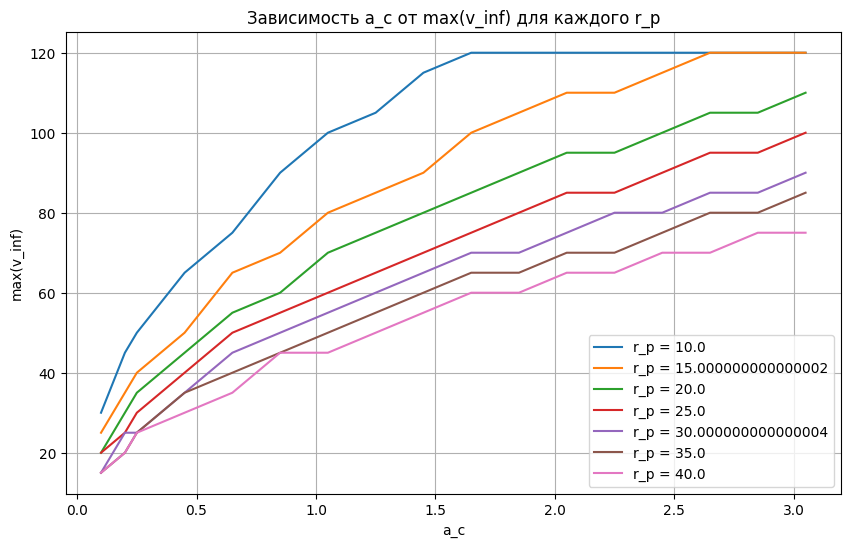

In [ ]:
import matplotlib.pyplot as plt

# Настройка для отображения графиков
plt.figure(figsize=(10, 6))

# Проходим по всем ключам и значениям из r_p_max_v_inf_dict
for r_p_val, a_c_max_v_inf_pairs in r_p_max_v_inf_dict.items():
    # Извлекаем значения a_c и max(v_inf)
    a_c_values = list(a_c_max_v_inf_pairs.keys())
    v_inf_values = list(a_c_max_v_inf_pairs.values())
    
    # Строим график для каждого r_p
    plt.plot(np.array(a_c_values) * CU * 1e6, np.array(v_inf_values) * VU, label=f"r_p = {r_p_val / R_sun_in_units}")

# Настройка графика
plt.xlabel('a_c')
plt.ylabel('max(v_inf)')
plt.title('Зависимость a_c от max(v_inf) для каждого r_p')
plt.legend()

# Отображение графика
plt.grid(True)
plt.show()



In [ ]:
# Функции для графиков
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# Построение 2D графика с использованием Plotly
def plot_2d_trajectories(trajectory_all, v_inf_values, ind):
    colors = ['pink', 'blue', 'green', 'red', 'black']
    fig = go.Figure()
    
    for i, trajectory in enumerate(trajectory_all):
        v_inf_index = min(i, len(v_inf_values) - 1)  # Ограничение индекса
        trace = go.Scatter(
            x=trajectory[:ind, 0],
            y=trajectory[:ind, 1],
            name=f'Trajectory for v_inf = {v_inf_values[v_inf_index] * VU} km/s',
            mode="lines",
            line=dict(width=2, color=colors[i % len(colors)])
        )
        fig.add_trace(trace)
        
        # Начальная точка
        start_marker = go.Scatter(
            x=[trajectory[0, 0]],
            y=[trajectory[0, 1]],
            name=f'Start {v_inf_values[v_inf_index] * VU} km/s',
            mode="markers",
            marker=dict(size=10, color=colors[i % len(colors)], symbol="circle")
        )
        fig.add_trace(start_marker)
    
    # Добавление Солнца
    fig.add_trace(go.Scatter(
        x=[0], y=[0],
        name="Sun",
        mode="markers",
        marker=dict(size=15, color="yellow")
    ))
    
    fig.update_layout(
        title="2D Trajectories",
        xaxis=dict(title="X (AU)"),
        yaxis=dict(title="Y (AU)"),
        width=800,
        height=600
    )
    fig.show()
def plot_3d_trajectories(trajectory_all, v_inf_values, ind):
    colors = ['pink', 'blue', 'green', 'red', 'black']
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    for i, trajectory in enumerate(trajectory_all):
        ax.plot(trajectory[:ind, 0], trajectory[:ind, 1], trajectory[:ind, 2],
                label=f'Trajectory for v_inf = {v_inf_values[i]} km/s',
                color=colors[i % len(colors)], linewidth=2)
    
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title('3D Trajectories')
    ax.legend()
    plt.show()

def plot_energies(times_all, energy_all, v_inf_values):
    """
    Строит красивые графики изменения удельной энергии от времени для различных v_inf.
    
    :param times_all: Список массивов времен для каждого v_inf
    :param energy_all: Список массивов энергий для каждого v_inf
    :param v_inf_values: Список значений v_inf
    """
    plt.figure(figsize=(12, 6), dpi=150)
    for times, energy, v_inf in zip(times_all, energy_all, v_inf_values):
        plt.plot(times, energy,  linewidth=2)
        plt.text(times[-1], energy[-1], f'v_inf = {v_inf * VU}', fontsize=10, verticalalignment='bottom')
    
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Энергия', fontsize=14)
    plt.title('Графики изменения энергии от времени для разных v_inf', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.5)
    plt.show()
    
def plot_distance_vs_energy(norms_all, energy_all, ind):
    fig = go.Figure()

    for i in range(len(norms_all)):  # Перебираем все траектории
        fig.add_trace(go.Scatter(
            x=norms_all[i][:ind], 
            y=energy_all[i][:ind], 
            mode='lines',
            name=f'Trajectory {i+1}'
        ))

    # Настройка графика
    fig.update_layout(
        title="Distance vs Energy",
        xaxis=dict(title="Distance (AU)", range=[-1, 7]),
        yaxis=dict(title="Energy"),
        width=1000,
        height=600,
        legend=dict(x=0.8, y=1),
        margin=dict(l=50, r=50, t=50, b=50)
    )

    fig.show()
    
def plot_smthing(array1, array2):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=array1, 
        y=array2, 
    
    ))

    # Настройка графика
    fig.update_layout(
        title="Distance vs Energy",
        xaxis=dict(title="Distanse", range=[-1, 7]),
        yaxis=dict(title="Eenergy"),
        width=1000,
        height=600,
        legend=dict(x=0.8, y=1),
        margin=dict(l=50, r=50, t=50, b=50)
    )

    fig.show()

In [ ]:
# # # Построение графиков


ind = times_all[1].shape[0]

# # norms_all = [np.linalg.norm(traj[:, 1:4], axis=1) for traj in trajectory_all[0:4]]

# # # Вызов функций
plot_2d_trajectories(trajectory_all[0:10], v_inf_values[0:10], ind)
# # #plot_smthing(norms[: ind], trajectory_all[:, :ind, 2])
# # #plot_3d_trajectories(trajectory_all[:, :ind, :], v_inf_values)
# plot_energies(times_all[:15], energy_all[:15], v_inf_values)
# # plot_distance_vs_energy(norms_all[0:4], energy_all[0:4], ind)

In [ ]:
r = trajectory_all[3][-1, :3]
v = trajectory_all[3][-1, 3:6]

np.dot(r, v)

np.float64(7.734706484960759e-06)